In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setup

In [161]:
df = pd.read_excel("stock_ardl2.xlsx")
df

,date,ibov_returns,cpi_inflation,brl_dollar,interest_rates
0,1998-01-01,-0.046778,0.007097,0.005657,0.4290
1,1998-02-01,0.087551,0.004603,0.006608,0.4200
2,1998-03-01,0.130167,0.003397,0.005411,0.3854
3,1998-04-01,-0.022600,0.002397,0.006617,0.3655
4,1998-05-01,-0.156718,0.005001,0.005785,0.3330
...,...,...,...,...,...
296,2022-09-01,0.004693,-0.002900,0.020076,0.1375
297,2022-10-01,0.054527,0.005901,0.001621,0.1375
298,2022-11-01,-0.030602,0.004100,0.003027,0.1375
299,2022-12-01,-0.021825,0.006200,-0.004290,0.1375


In [99]:
df.index

RangeIndex(start=0, stop=301, step=1)

# Exploratory analysis

In [135]:
def plot_acf_pacf(df_ts, lags=12):
    print(plot_acf(df_ts, lags=lags))
    print(plot_pacf(df_ts, lags=lags, method="ols"))

Figure(432x288)
Figure(432x288)


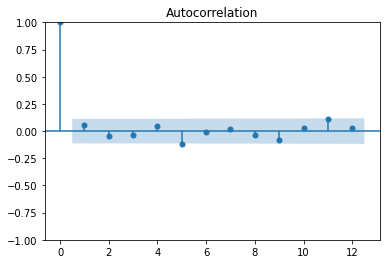

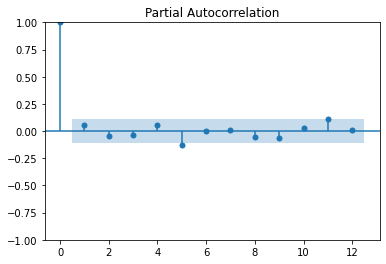

In [112]:
plot_acf_pacf(df.ibov_returns)

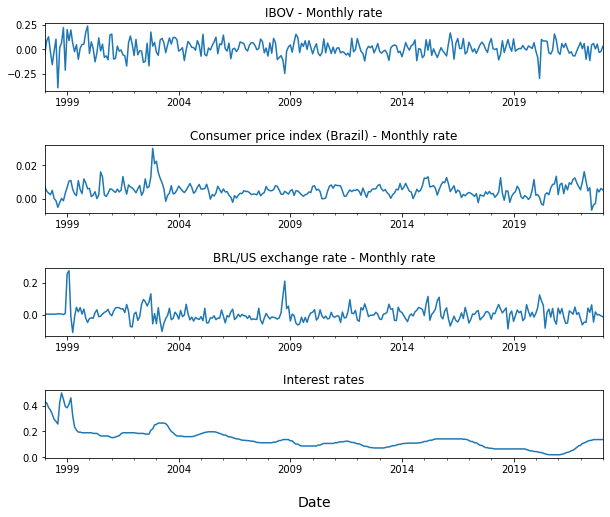

In [109]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.8})

# Convert the index to datetime
df.index = pd.to_datetime(df.date)

# Plot each time series in a separate subplot
df['ibov_returns'].plot(ax=axs[0], label='Series 1')
axs[0].set_title('IBOV - Monthly rate')
df['cpi_inflation'].plot(ax=axs[1], label='Series 2')
axs[1].set_title('Consumer price index (Brazil) - Monthly rate')
df['brl_dollar'].plot(ax=axs[2], label='Series 3')
axs[2].set_title('BRL/US exchange rate - Monthly rate')
df['interest_rates'].plot(ax=axs[3], label='Series 4')
axs[3].set_title('Interest rates')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')

fig.text(0.5, 0.04, 'Date', ha='center', fontsize=14)

# Display the plot
plt.show()

In [157]:
df[['ibov_returns','cpi_inflation','brl_dollar','interest_rates']].describe()

,ibov_returns,cpi_inflation,brl_dollar,interest_rates
count,301.000000,301.000000,301.000000,301.000000
mean,0.011314,0.005045,0.006057,0.138675
std,0.079540,0.004077,0.044277,0.078516
min,-0.395536,-0.006800,-0.106628,0.020000
25%,-0.034427,0.002600,-0.020443,0.089000
50%,0.008774,0.004603,0.003677,0.126200
75%,0.063026,0.006998,0.025510,0.172500
max,0.240438,0.030202,0.273876,0.497500


# ARDL model

$$ IBOV = \beta_0 + \beta_1IBOV_{t-1} + \sum_{j=0}^{5} \alpha_jER_{t-j} + \sum_{j=0}^{5} \gamma_jCPI_{t-j} \sum_{j=0}^{5} \delta_jIR_{t-j} + \varepsilon_t

In [168]:
# Setting the exogenous variables
exog=df.loc[:, ~df.columns.isin(["ibov_returns", "date"])]

# Define the range of lag values to test
max_lags = 6
lags_range = range(1, max_lags+1)

# Initialize the list of AIC values for each lag combination
aic_list = []

# Loop over the range of lags and fit the ARDL model for each combination
for p in lags_range:
    for q in lags_range:
        model = ARDL(df.ibov_returns, p, exog, q)
        results = model.fit()
        aic = results.aic
        aic_list.append((p, q, aic))

# Find the combination of lags that returns the lowest AIC value
best_lags = min(aic_list, key=lambda x: x[2])
print("Best combination of lags: ({}, {}) with AIC = {}".format(best_lags[0], best_lags[1], best_lags[2]))

Best combination of lags: (1, 5) with AIC = -701.6208219965253


In [169]:
model = ARDL(df.ibov_returns, 1, exog, 5).fit(cov_type="HAC", cov_kwds={'maxlags':2})
print(model.summary())

                              ARDL Model Results                              
Dep. Variable:           ibov_returns   No. Observations:                  301
Model:               ARDL(1, 5, 5, 5)   Log Likelihood                 371.810
Method:               Conditional MLE   S.D. of innovations              0.070
Date:                Mon, 08 May 2023   AIC                           -701.621
Time:                        15:03:05   BIC                           -623.841
Sample:                             5   HQIC                          -670.493
                                  301                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0070      0.009      0.777      0.438      -0.011       0.025
ibov_returns.L1      -0.0679      0.067     -1.015      0.311      -0.200       0.064
cpi_inflation.L0     -0.

- Durbin-Watson test for residuals

In [139]:
import statsmodels.api as sm

# Test for first-order serial correlation using the Durbin-Watson test
durbin_watson = sm.stats.stattools.durbin_watson(model.resid)

# Print the test result
print("Durbin-Watson statistic:", durbin_watson)

Durbin-Watson statistic: 2.025237215392498


- Breusch-Pagan for heteroskedasticity

In [144]:
# Add a constant column to your independent variable array
x_with_const = sm.add_constant(model.model.exog[5:])

# Run the Breusch-Pagan test for heteroscedasticity
bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, x_with_const)

# Print the test results
print('Breusch-Pagan test statistic: ', bp_test[0])
print('Breusch-Pagan test p-value: ', bp_test[1])

Breusch-Pagan test statistic:  24.54637794918741
Breusch-Pagan test p-value:  1.920770479956453e-05


- Jarque-Bera test for residuals

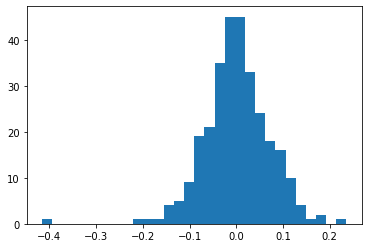

In [170]:
plt.hist(model.resid, bins=30)
fig = plt.gcf()
fig.set_facecolor("white")
plt.show()

In [171]:
import numpy as np
from scipy import stats

jarque_bera_test = stats.jarque_bera(model.resid)
jarque_bera_test

Jarque_beraResult(statistic=195.56316426728773, pvalue=0.0)

In [147]:
print(jarque_bera_test.statistic)
print(jarque_bera_test.pvalue)

195.56316426728773
0.0


# Augmented Ducky Fuller (ADF) TEST

A null hypothesis is given as:

* 𝐻0
  : Time series is not stationary
* 𝐻1
  : Time series is stationary


In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.apply(lambda x: round(x, 4)))

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [32]:
df.columns

Index(['date', 'ibov_returns', 'cpi_inflation', 'brl_dollar',
       'interest_rates'],
      dtype='object')

In [6]:
adf_test(df.ibov_returns)

Results of Dickey-Fuller Test:
Test Statistic                 -16.3567
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    300.0000
Critical Value (1%)             -3.4523
Critical Value (5%)             -2.8712
Critical Value (10%)            -2.5719
dtype: float64


In [7]:
adf_test(df.cpi_inflation)

Results of Dickey-Fuller Test:
Test Statistic                  -8.3120
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    300.0000
Critical Value (1%)             -3.4523
Critical Value (5%)             -2.8712
Critical Value (10%)            -2.5719
dtype: float64


In [8]:
adf_test(df.interest_rates)

Results of Dickey-Fuller Test:
Test Statistic                  -3.3273
p-value                          0.0137
#Lags Used                       3.0000
Number of Observations Used    297.0000
Critical Value (1%)             -3.4526
Critical Value (5%)             -2.8713
Critical Value (10%)            -2.5720
dtype: float64


In [9]:
adf_test(df.brl_dollar)

Results of Dickey-Fuller Test:
Test Statistic                 -11.5323
p-value                          0.0000
#Lags Used                       0.0000
Number of Observations Used    300.0000
Critical Value (1%)             -3.4523
Critical Value (5%)             -2.8712
Critical Value (10%)            -2.5719
dtype: float64


# ECM (error correction model)

$$ \Delta IBOV = \beta_0 + \beta_1 \Delta IBOV_{t-1} + \sum_{j=0}^{4} \alpha_j \Delta ER_{t-j} + \sum_{j=0}^{4} \gamma_j \Delta CPI_{t-j} \sum_{j=0}^{4} \delta_j \Delta IR_{t-j} + \varphi Z_{t-1} + \varepsilon_t

In [176]:
df["residuals"] = model.resid
df["residuals_t_1"] = df.residuals.shift(1)
df

,date,ibov_returns,cpi_inflation,brl_dollar,interest_rates,residuals,residuals_t_1
0,1998-01-01,-0.046778,0.007097,0.005657,0.4290,NaN,NaN
1,1998-02-01,0.087551,0.004603,0.006608,0.4200,NaN,NaN
2,1998-03-01,0.130167,0.003397,0.005411,0.3854,NaN,NaN
3,1998-04-01,-0.022600,0.002397,0.006617,0.3655,NaN,NaN
4,1998-05-01,-0.156718,0.005001,0.005785,0.3330,NaN,NaN
...,...,...,...,...,...,...,...
296,2022-09-01,0.004693,-0.002900,0.020076,0.1375,-0.014324,0.010238
297,2022-10-01,0.054527,0.005901,0.001621,0.1375,0.005616,-0.014324
298,2022-11-01,-0.030602,0.004100,0.003027,0.1375,-0.077710,0.005616
299,2022-12-01,-0.021825,0.006200,-0.004290,0.1375,-0.045471,-0.077710


In [177]:
var_list = ['ibov_returns', 'cpi_inflation', 'brl_dollar', 'interest_rates']
# Use a list comprehension to calculate the first difference of each variable in the `var_list`
diffs = [df[var].diff() for var in var_list]

# Use the `concat()` method to combine the resulting differences into a new DataFrame
diff_data = pd.concat(diffs, axis=1)
diff_data.columns = [i+"_diff_1" for i in var_list]
diff_data

diff_data = pd.concat([df.reset_index(drop=True), diff_data.reset_index(drop=True)], axis=1)
diff_data

,date,ibov_returns,cpi_inflation,brl_dollar,interest_rates,residuals,residuals_t_1,ibov_returns_diff_1,cpi_inflation_diff_1,brl_dollar_diff_1,interest_rates_diff_1
0,1998-01-01,-0.046778,0.007097,0.005657,0.4290,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-02-01,0.087551,0.004603,0.006608,0.4200,NaN,NaN,0.134330,-0.002494,0.000950,-0.0090
2,1998-03-01,0.130167,0.003397,0.005411,0.3854,NaN,NaN,0.042616,-0.001206,-0.001197,-0.0346
3,1998-04-01,-0.022600,0.002397,0.006617,0.3655,NaN,NaN,-0.152767,-0.001000,0.001206,-0.0199
4,1998-05-01,-0.156718,0.005001,0.005785,0.3330,NaN,NaN,-0.134119,0.002604,-0.000832,-0.0325
...,...,...,...,...,...,...,...,...,...,...,...
296,2022-09-01,0.004693,-0.002900,0.020076,0.1375,-0.014324,0.010238,-0.056936,0.000699,0.062511,0.0005
297,2022-10-01,0.054527,0.005901,0.001621,0.1375,0.005616,-0.014324,0.049834,0.008801,-0.018455,0.0000
298,2022-11-01,-0.030602,0.004100,0.003027,0.1375,-0.077710,0.005616,-0.085129,-0.001801,0.001406,0.0000
299,2022-12-01,-0.021825,0.006200,-0.004290,0.1375,-0.045471,-0.077710,0.008777,0.002100,-0.007317,0.0000


In [33]:
[i+"_diff_1" for i in var_list]

['ibov_returns_diff_1',
 'cpi_inflation_diff_1',
 'brl_dollar_diff_1',
 'interest_rates_diff_1']

In [178]:
diff_data.dropna()

,date,ibov_returns,cpi_inflation,brl_dollar,interest_rates,residuals,residuals_t_1,ibov_returns_diff_1,cpi_inflation_diff_1,brl_dollar_diff_1,interest_rates_diff_1
6,1998-07-01,0.106324,-0.001199,0.006151,0.2780,0.094193,-0.084367,0.123486,-0.001397,0.000225,-0.0161
7,1998-08-01,-0.395536,-0.005097,0.008869,0.2575,-0.415667,0.094193,-0.501859,-0.003898,0.002718,-0.0205
8,1998-09-01,0.018696,-0.002202,0.007510,0.4234,-0.072727,-0.415667,0.414232,0.002896,-0.001358,0.1659
9,1998-10-01,0.068861,0.000199,0.007116,0.4975,0.011976,-0.072727,0.050165,0.002401,-0.000395,0.0741
10,1998-11-01,0.224777,-0.001203,0.003617,0.4488,0.152517,0.011976,0.155916,-0.001402,-0.003499,-0.0487
...,...,...,...,...,...,...,...,...,...,...,...
296,2022-09-01,0.004693,-0.002900,0.020076,0.1375,-0.014324,0.010238,-0.056936,0.000699,0.062511,0.0005
297,2022-10-01,0.054527,0.005901,0.001621,0.1375,0.005616,-0.014324,0.049834,0.008801,-0.018455,0.0000
298,2022-11-01,-0.030602,0.004100,0.003027,0.1375,-0.077710,0.005616,-0.085129,-0.001801,0.001406,0.0000
299,2022-12-01,-0.021825,0.006200,-0.004290,0.1375,-0.045471,-0.077710,0.008777,0.002100,-0.007317,0.0000


In [187]:
diff_exog_variables = ['cpi_inflation_diff_1','brl_dollar_diff_1','interest_rates_diff_1', 'residuals_t_1']

df_ecm = diff_data[['ibov_returns_diff_1', 'cpi_inflation_diff_1','brl_dollar_diff_1','interest_rates_diff_1', 'residuals_t_1']].dropna()

# Setting the exogenous variables
exog=df_ecm.loc[:, diff_exog_variables]
model_ecm = ARDL(
    df_ecm.ibov_returns_diff_1, 1, 
    exog, {
        'cpi_inflation_diff_1':4,
        'brl_dollar_diff_1':4,
        'interest_rates_diff_1':4, 
        'residuals_t_1':0}
).fit()
print(model_ecm.summary())

                               ARDL Model Results                              
Dep. Variable:     ibov_returns_diff_1   No. Observations:                  295
Model:             ARDL(1, 4, 4, 4, 0)   Log Likelihood                 374.255
Method:                Conditional MLE   S.D. of innovations              0.068
Date:                 Mon, 08 May 2023   AIC                           -710.509
Time:                         15:32:05   BIC                           -640.521
Sample:                              4   HQIC                          -682.481
                                   295                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0015      0.004      0.355      0.723      -0.007       0.010
ibov_returns_diff_1.L1      -0.0871      0.059     -1.487      0.138      -0.202 

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Bounds cointegration test

$$ \Delta IBOV = \beta_0 + \beta_1 \Delta IBOV_{t-1} + \phi_0 ER_{t-1} + \phi_1 CPI_{t-1} + \phi_2 IR_{t-1} + \sum_{j=0}^{4} \alpha_j \Delta ER_{t-j} + \sum_{j=0}^{4} \gamma_j \Delta CPI_{t-j} \sum_{j=0}^{4} \delta_j \Delta IR_{t-j} + \varepsilon_t

In [180]:
diff_data

,date,ibov_returns,cpi_inflation,brl_dollar,interest_rates,residuals,residuals_t_1,ibov_returns_diff_1,cpi_inflation_diff_1,brl_dollar_diff_1,interest_rates_diff_1
0,1998-01-01,-0.046778,0.007097,0.005657,0.4290,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-02-01,0.087551,0.004603,0.006608,0.4200,NaN,NaN,0.134330,-0.002494,0.000950,-0.0090
2,1998-03-01,0.130167,0.003397,0.005411,0.3854,NaN,NaN,0.042616,-0.001206,-0.001197,-0.0346
3,1998-04-01,-0.022600,0.002397,0.006617,0.3655,NaN,NaN,-0.152767,-0.001000,0.001206,-0.0199
4,1998-05-01,-0.156718,0.005001,0.005785,0.3330,NaN,NaN,-0.134119,0.002604,-0.000832,-0.0325
...,...,...,...,...,...,...,...,...,...,...,...
296,2022-09-01,0.004693,-0.002900,0.020076,0.1375,-0.014324,0.010238,-0.056936,0.000699,0.062511,0.0005
297,2022-10-01,0.054527,0.005901,0.001621,0.1375,0.005616,-0.014324,0.049834,0.008801,-0.018455,0.0000
298,2022-11-01,-0.030602,0.004100,0.003027,0.1375,-0.077710,0.005616,-0.085129,-0.001801,0.001406,0.0000
299,2022-12-01,-0.021825,0.006200,-0.004290,0.1375,-0.045471,-0.077710,0.008777,0.002100,-0.007317,0.0000


In [213]:
diff_exog_variables = ['brl_dollar', 'cpi_inflation', 'interest_rates', 'cpi_inflation_diff_1','brl_dollar_diff_1','interest_rates_diff_1']

df_ecm_bounds = diff_data[['brl_dollar', 'cpi_inflation', 'interest_rates', 'ibov_returns_diff_1', 'cpi_inflation_diff_1','brl_dollar_diff_1','interest_rates_diff_1']].dropna()

# Setting the exogenous variables
exog=df_ecm_bounds.loc[:, diff_exog_variables]
model_ecm_bounds = ARDL(
    df_ecm_bounds.ibov_returns_diff_1, 1, 
    exog, {
        'brl_dollar':[1], 
        'cpi_inflation':[1], 
        'interest_rates':[1],
        'cpi_inflation_diff_1':4,
        'brl_dollar_diff_1':4,
        'interest_rates_diff_1':4}
).fit(cov_type="HAC", cov_kwds={'maxlags':2})
print(model_ecm_bounds.summary())

model_ecm_bounds_RESTRICTED = ARDL(
    df_ecm_bounds.ibov_returns_diff_1, 1, 
    exog, {
        'cpi_inflation':[1], 
        'interest_rates':[1],
        'cpi_inflation_diff_1':4,
        'brl_dollar_diff_1':4,
        'interest_rates_diff_1':4}
).fit()

                                  ARDL Model Results                                 
Dep. Variable:           ibov_returns_diff_1   No. Observations:                  300
Model:             ARDL(1, 1, 1, 1, 4, 4, 4)   Log Likelihood                 309.272
Method:                      Conditional MLE   S.D. of innovations              0.086
Date:                       Mon, 08 May 2023   AIC                           -576.543
Time:                               17:07:10   BIC                           -498.834
Sample:                                    4   HQIC                          -545.440
                                         300                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0011      0.011      0.105      0.916      -0.020       0.023
ibov_returns_diff_1.L1      -0.51

/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gabrieldiasmp/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ardl/model.py:458: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: brl_dollar.
  return _format_order(self.data.orig_exog, order, self._causal)


In [214]:
model_ecm_bounds_RESTRICTED.resid.apply(lambda x: x**2).sum()

2.2375813059292247

In [215]:
model_ecm_bounds.resid.apply(lambda x: x**2).sum()

2.211917737056952

In [217]:
rrss = model_ecm_bounds_RESTRICTED.resid.apply(lambda x: x**2).sum()
urss = model_ecm_bounds.resid.apply(lambda x: x**2).sum()

print(f'Bounds cointegration F-test: {((rrss - urss)/1)/(urss/(296-20))}') ## The critical value is 3.1

Bounds cointegration F-test: 3.202264211765695


In [204]:
((rrss - urss)/3)/(urss/(296-20))

1.5748585053093505

- Durbin-watson serial correlation test

In [87]:
import statsmodels.api as sm

# Test for first-order serial correlation using the Durbin-Watson test
durbin_watson = sm.stats.stattools.durbin_watson(model_ecm.resid)

# Print the test result
print("Durbin-Watson statistic:", durbin_watson)

Durbin-Watson statistic: 2.013162758973414


- White test for heteroskedasticity test

In [94]:
# Add a constant column to your independent variable array
x_with_const = sm.add_constant(model_ecm.model.exog[2:])

# Run the Breusch-Pagan test for heteroscedasticity
bp_test = sm.stats.diagnostic.het_white(model_ecm.resid, x_with_const)

# Print the test results
print('White test statistic: ', bp_test[0])
print('White test p-value: ', bp_test[1])

White test statistic:  71.63951342300844
White test p-value:  9.7271690153347e-10


In [88]:
model_ecm.test_heteroskedasticity()

,ARCH-LM,P-value,DF
Lag,,,
1,10.346381,1.297288e-03,1
2,10.544726,5.131471e-03,2
3,32.385175,4.341100e-07,3
4,68.630616,4.415847e-14,4
5,94.627395,7.152547e-19,5
6,104.294201,3.183354e-20,6
7,92.700458,3.447036e-17,7
8,21.381550,6.200051e-03,8
9,12.312241,1.962735e-01,9
